Query AODN parquet dataset:

Creation of a python class ```GetAodn``` to:
- retrieve as a dictionnary all metadata from all parquet dataset available on a S3 bucket 
- search for dataset containing specific variable/attributes ....
- retrieve data from a dataset with time and bounding box filter as a panda dataframe

In [1]:
!pip install fuzzywuzzy
!pip install s3fs -U
!pip install pyarrow==16.0.0 -U
!pip install zarr xarray[complete]
!pip install pandas==2.2.2 -U

In [2]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/IMOS-hackathon/main/2024/Tutorials/cloud_optimised_notebooks/parquet_queries.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)


In [3]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc
import boto3
from fuzzywuzzy import fuzz
from botocore import UNSIGNED
from botocore.client import Config

/home/lbesnard/miniforge3/envs/CloudOptimisedParquet/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# GetAodn Class definition

In [4]:
class GetAodn:
    def __init__(self):
        self.bucket_name = "imos-data-lab-optimised"
        self.prefix = 'parquet/loz_test'
        
    def get_dataset(self, dataset_name):
        return Dataset(self.bucket_name, self.prefix, dataset_name)

        
    def get_metadata(self):
        return Metadata(self.bucket_name, self.prefix)

class Dataset:
    def __init__(self, bucket_name, prefix, dataset_name):
        self.bucket_name = bucket_name
        self.prefix = prefix
        self.dataset_name = dataset_name
        self.dname = f"s3://{self.bucket_name}/{self.prefix}/{self.dataset_name}.parquet/"
        self.parquet_ds = pq.ParquetDataset(self.dname, partitioning='hive')
        
    def partition_keys_list(self):
        dataset = pq.ParquetDataset(self.dname, format="parquet", partitioning="hive")
        partition_keys = dataset.partitioning.schema
        return partition_keys

    def get_spatial_extent(self):
        return get_spatial_extent(self.parquet_ds)

    def plot_spatial_extent(self):
        return plot_spatial_extent(self.parquet_ds)

    def get_temporal_extent(self):
        return get_temporal_extent(self.parquet_ds)

    def get_data(self, date_start=None, date_end=None, lat_min=None, lat_max=None, lon_min=None, lon_max=None):
        filter_time = create_time_filter(self.parquet_ds, date_start=date_start, date_end=date_end)
        filter_geo = create_bbox_filter(self.parquet_ds, lat_min=lat_min, lat_max=lat_max, lon_min=lon_min, lon_max=lon_max)
        data_filter = filter_geo & filter_time
        df = pd.read_parquet(self.dname, engine='pyarrow', filters=data_filter)
        return df

    def get_metadata(self):
         return get_schema_metadata(self.dname)

class Metadata:
        def __init__(self, bucket_name, prefix):
            #super().__init__()
            # initialise the class by calling the needed methods
            self.bucket_name = bucket_name
            self.prefix = prefix
            self.catalog = self.metadata_catalog()

            
        def metadata_catalog(self):
            folders_with_parquet = self.list_folders_with_parquet()
            
            catalog = dict()
            for dataset in folders_with_parquet:
                dname = f"s3://{self.bucket_name}/{dataset}"
                
                metadata = get_schema_metadata(dname)  # schema metadata
            
                path_parts = dataset.strip('/').split('/')
                last_folder_with_extension = path_parts[-1]
                
                dataset_name = os.path.splitext(last_folder_with_extension)[0]
                    
                catalog[dataset_name] = metadata
    
            return catalog
        
        def list_folders_with_parquet(self):
            s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
            
            prefix = self.prefix
            if not prefix.endswith('/'):
                prefix += '/'
        
            response = s3.list_objects_v2(
                Bucket=self.bucket_name,
                Prefix=prefix,
                Delimiter='/'
            )
        
            folders = []
            for prefix in response.get('CommonPrefixes', []):
                folder_path = prefix['Prefix']
                if folder_path.endswith('.parquet/'):
                    # Extracting the folder name without the prefix
                    folder_name = folder_path[len(prefix) - 1:]
                    folders.append(folder_name)
        
            return folders
    
        def find_datasets_with_attribute(self, target_value, target_key='standard_name',data_dict=None, threshold=80):

            matching_datasets = []
            # https://stackoverflow.com/questions/56535948/python-why-cant-you-use-a-self-variable-as-an-optional-argument-in-a-method
            if data_dict == None:
                data_dict = self.catalog
        
            if not isinstance(data_dict, dict):
                return matching_datasets # handle bad cases
                
            for dataset_name, attributes in data_dict.items():
                if not isinstance(attributes, dict):
                    continue  
        
                for key, value in attributes.items():
                    if isinstance(value, dict) and target_key in value:
                        # Check for any attribute available in a dict(catalog) match using fuzzy matching
                        current_standard_name = value.get(target_key, '')
                        similarity_score = fuzz.partial_ratio(target_value.lower(), current_standard_name.lower())
                        if similarity_score >= threshold:
                            matching_datasets.append(dataset_name)  # Add dataset name to list
        
                    # Recursively search
                    matching_datasets.extend(self.find_datasets_with_attribute(value, target_value, threshold))
        
            return list(set(matching_datasets))

## Examples to use class

In [5]:
aodn_instance = GetAodn()

In [6]:
aodn_instance.get_metadata().metadata_catalog()

{'aatams_acoustic_tagging': {'detection_timestamp': {'type': 'timestamp[ns]',
   'standard_name': 'time',
   'long_name': '',
   'units': 's',
   'comments': ''},
  'transmitter_id': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'installation_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'station_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'receiver_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'latitude': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'longitude': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'sensor_value': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'sensor_unit': 

In [7]:
aodn_instance.get_metadata().find_datasets_with_attribute('temp', target_key='standard_name' )

['argo_core', 'soop_xbt_nrt']

In [8]:
aodn_instance.get_dataset('soop_xbt_nrt').get_temporal_extent()

(datetime.datetime(2020, 9, 1, 10, 0), datetime.datetime(2024, 4, 1, 11, 0))

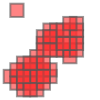

In [9]:
aodn_instance.get_dataset('soop_xbt_nrt').get_spatial_extent()

In [10]:
df = aodn_instance.get_dataset('soop_xbt_nrt').get_data(date_start='2023-01-31 10:14:00', 
                                                   date_end='2024-02-01 07:50:00',
                                                   lat_min=-34, lat_max=-32, lon_min=150, lon_max=155)
                                                   


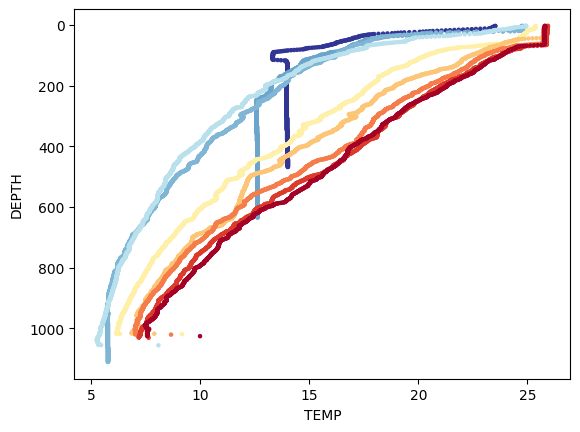

In [11]:
df[df['TEMP_quality_control'] == 1].sort_values('TIME').plot.scatter(x='TEMP', y='DEPTH', c='TIME',                                                                      
                                                                     cmap='RdYlBu_r', marker='.', linestyle="None").invert_yaxis()

In [12]:
df

,TIME,LATITUDE,LONGITUDE,DEPTH,DEPTH_quality_control,TEMP,TEMP_quality_control,imo_number,ship_name,Callsign,filename,XBT_line,timestamp,polygon
0,2024-01-28 05:41:00,-32.97142,151.99845,0.00,9.0,23.59,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
1,2024-01-28 05:41:00,-32.97142,151.99845,0.67,9.0,23.58,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
2,2024-01-28 05:41:00,-32.97142,151.99845,1.34,9.0,23.57,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
3,2024-01-28 05:41:00,-32.97142,151.99845,2.01,9.0,23.56,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
4,2024-01-28 05:41:00,-32.97142,151.99845,2.68,9.0,23.54,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14188,2024-01-28 21:01:00,-33.20854,154.99796,1107.43,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14189,2024-01-28 21:01:00,-33.20854,154.99796,1108.17,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14190,2024-01-28 21:01:00,-33.20854,154.99796,1108.91,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14191,2024-01-28 21:01:00,-33.20854,154.99796,1109.65,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
